In [1]:
import polars as pl
import numpy as np
import os
from bellman_filter_dfsv.filters.bellman_information import DFSVBellmanInformationFilter
from bellman_filter_dfsv.models.dfsv import DFSVParamsDataclass
from bellman_filter_dfsv.utils.optimization import run_optimization
from bellman_filter_dfsv.filters.particle import DFSVParticleFilter
from bellman_filter_dfsv.utils.optimization import FilterType
from bellman_filter_dfsv.utils.optimization_helpers import create_stable_initial_params
import time
import pandas as pd
import jax
import jax.numpy as jnp
import cloudpickle
import pickle
from pathlib import Path
from rich import print
jax.config.update("jax_enable_x64", True)
df =pl.read_csv("../../vw_returns_final.csv")
df.head()
df_with_date=pl.read_csv("../../vw_returns_final_with_date.csv")
# os.getcwd()
returns=df.to_jax()
N=95
K=5
T=returns.shape[0]

In [3]:
#Load pickle file
with open('bif_full_result_20250425_144625.pkl', 'rb') as f:
# with open('pf_full_result_20250425_194312.pkl', 'rb') as f:
    result_bif = cloudpickle.load(f)
bif_filter=DFSVBellmanInformationFilter(N,K)
# bif_filter=DFSVParticleFilter(N,K,num_particles=10000)
bif_params=result_bif.final_params
print(round(bif_params.Phi_f,3))
filtered_states_bf,filtered_infos_bf,log_likelihood_bf=bif_filter.filter(bif_params,returns)
print(log_likelihood_bf)

[[ 0.112  0.646 -0.155  0.041 -0.129]
 [-0.225  0.294 -0.259 -0.014 -0.082]
 [-0.247  0.327 -0.492  0.21   0.12 ]
 [-0.139  0.208 -0.395  0.344  0.185]
 [-0.084  0.146 -0.258  0.2    0.141]]

Bellman Information Filtering (Python Loop): 100%|██████████| 738/738 [00:05<00:00, 142.40it/s]


222084.10371757764

In [4]:
result_bif.time_taken

10511.067908525467

In [50]:
filtered_covs_bf=np.array(bif_filter.get_filtered_covariances())
filtered_factors_bf=filtered_states_bf[:,:K]
predicted_states_bf=np.array(bif_filter.get_predicted_states())
predicted_factors_bf=predicted_states_bf[:,:K]
predicted_covs_bf=np.array(bif_filter.get_predicted_covariances())

#Calculate standardized residuals z_t

In [51]:
returns_arr=np.array(returns)
lambda_hat_bif=np.array(bif_params.lambda_r)
sigma_eps_hat_diag_bif=np.array(bif_params.sigma2)
sigma_eps_hat_mat_bif=np.diag(sigma_eps_hat_diag_bif)

predicted_factor_covs_bif=predicted_covs_bf[:,:K,:K]
filtered_factor_covs_bif=filtered_covs_bf[:,:K,:K]

standardized_residuals_bif = np.full((T,N),np.nan)
conditional_covariance_H_bif = np.full((T, N, N), np.nan) # Store Sigma_t|t-1

for t in range(T):
    # P_f_t_filt = filtered_factor_covs_bif[t, :, :] # Shape (K, K)
    # f_t_filt = filtered_factors_bf[t, :] # Shape (K,)

    # # Calculate conditional observation covariance Sigma_{t|t-1}
    # # Calculate conditional observation covariance Sigma_{t|t}
    # Sigma_t_filt = lambda_hat_bif @ P_f_t_filt @ lambda_hat_bif.T + sigma_eps_hat_mat_bif # Use sigma_eps_hat_mat_bif
    # Sigma_t_filt = (Sigma_t_filt + Sigma_t_filt.T) / 2 # Ensure symmetryc
    # pull predicted (t|t-1) objects
    f_t_pred = predicted_factors_bf[t,:]              # K-vector
    P_f_pred = predicted_factor_covs_bif[t,:,:]        # K×K

    mu_t_pred = lambda_hat_bif @ f_t_pred
    Sigma_t_pred = (lambda_hat_bif @ P_f_pred @ lambda_hat_bif.T
                    + sigma_eps_hat_mat_bif)
    Sigma_t_pred = (Sigma_t_pred + Sigma_t_pred.T) / 2  # enforce symmetry
    Sigma_t_filt=Sigma_t_pred
    f_t_filt=f_t_pred

    conditional_covariance_H_bif[t, :, :] = Sigma_t_filt # Store it

    try:
        # Cholesky: Sigma_{t|t-1} = L * L'
        L_t_pred = np.linalg.cholesky(Sigma_t_filt + 1e-7 * np.eye(N)) # Add jitter
        # Raw residual e_t = r'_t (since mean is zero for demeaned returns)
        mu_t_filt = lambda_hat_bif @ f_t_filt # Shape (N,) -> Filtered mean
        e_t = returns_arr[t, :] - mu_t_filt # Shape (N,) -> Corrected residual
        # Standardized residual: z_t = L^{-1} * e_t
        z_t = np.linalg.solve(L_t_pred, e_t)
        standardized_residuals_bif[t, :] = z_t
    except np.linalg.LinAlgError:
        print(f"Warning: Cholesky failed for Sigma_t|t-1 at t={t} for BIF.")
        # standardized_residuals_bif[t, :] remains NaN

# Convert to DataFrame (similar to 02_factor_cv_fit.py)
standardized_residuals_bif_df = pd.DataFrame(
    standardized_residuals_bif,
)
# Define burn-in for analysis if needed (e.g., analysis_burn_in = 50)
analysis_burn_in = 0
standardized_residuals_bif_post_burn = standardized_residuals_bif_df.iloc[analysis_burn_in:]

In [52]:
standardized_residuals_bif_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,0.010696,-0.031475,0.007258,-0.122793,0.291021,-0.363248,-0.382238,-0.477813,-0.466625,0.120191,...,0.146898,1.121875,0.349499,-0.190194,0.985953,0.322564,0.942647,0.923177,0.242632,1.010178
1,-0.213020,1.312428,0.573528,-1.085852,-0.025591,0.160021,0.337444,1.282051,1.678432,1.089462,...,0.989346,0.657912,0.495395,0.160030,-0.178642,-0.510289,-0.717564,-0.394114,0.722914,0.175435
2,0.388114,-2.083669,-0.146810,0.181684,-0.234621,-1.684734,-0.117286,-1.868742,-1.743609,0.528673,...,-0.637707,-1.124540,-0.182330,0.703813,-0.221267,1.248066,-0.292906,0.291785,-0.298616,0.346435
3,-0.245238,1.969498,0.197297,-0.633027,0.730873,-1.538323,0.111812,0.912352,-0.316409,0.045304,...,1.969494,-0.437950,-0.463396,1.015001,3.177345,-0.184319,-0.143361,-1.311705,-0.249927,-1.215012
4,0.118036,-2.066491,-0.797868,-1.141406,-0.243616,-0.116233,-0.335841,0.060967,-0.131794,-0.114851,...,-1.062766,0.555373,1.378275,0.372532,-1.764314,1.433742,-0.411736,-1.064519,-0.037397,-0.894009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,-1.322494,0.372748,0.403103,2.983389,-0.543193,-0.375657,-2.433753,-0.185650,-1.422164,1.462587,...,0.602113,0.002946,-0.239257,-0.210217,-1.776504,1.354209,0.579144,-0.162889,-2.059541,0.332706
734,-0.808938,0.873004,-0.168616,1.459691,0.006713,-0.438532,-2.443729,0.077908,-0.509878,0.237292,...,-0.755945,0.567908,-0.157453,-0.477150,-0.445372,1.439961,-0.382238,-1.013006,-0.497894,-0.921271
735,0.030896,1.153381,0.350261,-1.172682,0.107973,-2.437272,2.706244,-2.227288,-1.396291,-0.367088,...,-0.675272,0.969352,0.961220,-0.656724,-0.485114,-0.621853,-0.440658,-0.098297,-0.159592,1.190303
736,1.441825,0.098340,3.136797,3.543967,-1.700578,-0.649236,1.887696,-1.756290,1.933520,-2.118248,...,-1.392359,-0.518529,0.409152,-0.046346,-0.186477,-0.532918,-0.956829,0.831898,-0.841434,1.962310


In [53]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
import warnings
#  Also assume N (number of series) and T_eff (effective number of observations post-burn)
if 'standardized_residuals_bif_post_burn' in locals():
    residuals_df = standardized_residuals_bif_post_burn
    N = residuals_df.shape[1]
    T_eff = residuals_df.shape[0]
    print(f"Using BIF standardized residuals with shape: {residuals_df.shape}")
else:
    print("Error: standardized_residuals_bif_post_burn DataFrame not found.")
    # As a placeholder for testing the code structure:
    T_eff, N = 500, 95 # Example dimensions
    print(f"Creating placeholder DataFrame with shape ({T_eff}, {N})")
    residuals_df = pd.DataFrame(np.random.randn(T_eff, N), columns=[f'Asset_{i+1}' for i in range(N)])

# --- Dictionary to store test results ---
diagnostic_results_bif = {
    "ljung_box_squared": {},
    "arch_lm": {},
    "jarque_bera": {}
}

# Significance level for counting rejections/passes
alpha = 0.05

Using BIF standardized residuals with shape: (738, 95)

Ljung-Box

In [54]:
print(f"\n--- Running Ljung-Box Test (Squared Residuals) ---")
lags_lb = [5, 10, 15, 20] # Lags to test (similar to DFM script) [cite: 2]

for lag in lags_lb:
    lb_results = {
        "lag": lag,
        "pass_count": 0,
        "reject_count": 0,
        "error_count": 0,
        "total": N,
        "pass_rate": 0.0
    }
    print(f"Testing with lag = {lag}...")
    for i in range(N):
        col_name = residuals_df.columns[i]
        series_sq = residuals_df.iloc[:, i]**2
        # Drop NaN values which can cause issues, though standardized residuals shouldn't have them
        series_sq = series_sq.dropna()

        if len(series_sq) <= lag:
             print(f"  Skipping Series {i+1} ({col_name}): Not enough observations ({len(series_sq)}) for lag {lag}")
             lb_results["error_count"] += 1
             continue

        try:
            # Run the Ljung-Box test
            lb_test = acorr_ljungbox(series_sq, lags=[lag], return_df=True)
            p_value = lb_test.iloc[0, 1] # Get p-value for the specified lag

            # Check if null hypothesis is rejected (p-value <= alpha means reject H0 -> autocorrelation exists)
            if p_value <= alpha:
                lb_results["reject_count"] += 1
            else:
                # Fail to reject H0 -> No significant autocorrelation detected
                lb_results["pass_count"] += 1
        except Exception as e:
            # Handle potential errors during the test (e.g., constant series)
            # print(f"  Error testing Series {i+1} ({col_name}): {e}") # Optional: more verbose error
            lb_results["error_count"] += 1

    # Calculate pass rate (proportion of series where H0 is NOT rejected)
    if N > 0:
         # Calculate rate based on successfully tested series
        tested_count = N - lb_results["error_count"]
        if tested_count > 0:
            lb_results["pass_rate"] = lb_results["pass_count"] / tested_count
        else:
            lb_results["pass_rate"] = np.nan # Or 0.0 if preferred

    diagnostic_results_bif["ljung_box_squared"][f"lag_{lag}"] = lb_results
    print(f"Lag {lag}: Pass Rate = {lb_results['pass_rate']:.3f} ({lb_results['pass_count']}/{tested_count})")

print("Ljung-Box Test Complete.")

--- Running Ljung-Box Test (Squared Residuals) ---

Testing with lag = 5...

Lag 5: Pass Rate = 0.074 (7/95)

Testing with lag = 10...

Lag 10: Pass Rate = 0.095 (9/95)

Testing with lag = 15...

Lag 15: Pass Rate = 0.105 (10/95)

Testing with lag = 20...

Lag 20: Pass Rate = 0.126 (12/95)

Ljung-Box Test Complete.

In [55]:
print(f"\n--- Running ARCH-LM Test ---")
lags_arch = [5, 10] # Lags to test

for lag in lags_arch:
    arch_results = {
        "lag": lag,
        "pass_count": 0,
        "reject_count": 0,
        "error_count": 0,
        "total": N,
        "pass_rate": 0.0
    }
    print(f"Testing with lag = {lag}...")
    for i in range(N):
        col_name = residuals_df.columns[i]
        series = residuals_df.iloc[:, i].dropna()

        # het_arch requires length > nlags
        if len(series) <= lag:
             print(f"  Skipping Series {i+1} ({col_name}): Not enough observations ({len(series)}) for lag {lag}")
             arch_results["error_count"] += 1
             continue

        try:
            # Run the ARCH-LM test
            # Note: het_arch returns (lm_stat, lm_p_value, f_stat, f_p_value)
            lm_stat, p_value, f_stat, f_p_value = het_arch(series, nlags=lag)

            # Check if null hypothesis is rejected (p-value <= alpha means reject H0 -> ARCH effects exist)
            if p_value <= alpha:
                arch_results["reject_count"] += 1
            else:
                # Fail to reject H0 -> No significant ARCH effects detected
                arch_results["pass_count"] += 1
        except Exception as e:
            # Handle potential errors (e.g., perfect multicollinearity if lags are too high for T)
            # print(f"  Error testing Series {i+1} ({col_name}): {e}")
            arch_results["error_count"] += 1

    # Calculate pass rate
    if N > 0:
        tested_count = N - arch_results["error_count"]
        if tested_count > 0:
            arch_results["pass_rate"] = arch_results["pass_count"] / tested_count
        else:
             arch_results["pass_rate"] = np.nan

    diagnostic_results_bif["arch_lm"][f"lag_{lag}"] = arch_results
    print(f"Lag {lag}: Pass Rate = {arch_results['pass_rate']:.3f} ({arch_results['pass_count']}/{tested_count})")

print("ARCH-LM Test Complete.")

--- Running ARCH-LM Test ---

Testing with lag = 5...

Lag 5: Pass Rate = 0.095 (9/95)

Testing with lag = 10...

Lag 10: Pass Rate = 0.116 (11/95)

ARCH-LM Test Complete.

In [56]:
print(f"\n--- Running Jarque-Bera Normality Test ---")
jb_results = {
    "pass_count": 0,
    "reject_count": 0,
    "error_count": 0,
    "total": N,
    "pass_rate": 0.0
}

for i in range(N):
    col_name = residuals_df.columns[i]
    series = residuals_df.iloc[:, i].dropna()

    # Jarque-Bera test requires at least 2 observations
    if len(series) < 2:
         print(f"  Skipping Series {i+1} ({col_name}): Not enough observations ({len(series)})")
         jb_results["error_count"] += 1
         continue

    try:
        # Run the Jarque-Bera test
        # Returns (jb_statistic, jb_p_value, skewness, kurtosis)
        jb_stat, p_value, skew, kurt = jarque_bera(series)

        # Check if null hypothesis is rejected (p-value <= alpha means reject H0 -> not normal)
        if p_value <= alpha:
            jb_results["reject_count"] += 1
        else:
            # Fail to reject H0 -> Distribution is potentially normal
            jb_results["pass_count"] += 1
    except Exception as e:
        # Handle potential errors (e.g., zero variance series)
        # print(f"  Error testing Series {i+1} ({col_name}): {e}")
        jb_results["error_count"] += 1

# Calculate pass rate
if N > 0:
    tested_count = N - jb_results["error_count"]
    if tested_count > 0:
         jb_results["pass_rate"] = jb_results["pass_count"] / tested_count
    else:
        jb_results["pass_rate"] = np.nan

diagnostic_results_bif["jarque_bera"] = jb_results
print(f"Jarque-Bera: Pass Rate = {jb_results['pass_rate']:.3f} ({jb_results['pass_count']}/{tested_count})")

print("Jarque-Bera Test Complete.")

# --- Display aggregated results ---
print("\n--- BIF Diagnostic Test Summary ---")
import json
print(json.dumps(diagnostic_results_bif, indent=2))

--- Running Jarque-Bera Normality Test ---

Jarque-Bera: Pass Rate = 0.021 (2/95)

Jarque-Bera Test Complete.

--- BIF Diagnostic Test Summary ---

{
  "ljung_box_squared": {
    "lag_5": {
      "lag": 5,
      "pass_count": 7,
      "reject_count": 88,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.07368421052631578
    },
    "lag_10": {
      "lag": 10,
      "pass_count": 9,
      "reject_count": 86,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.09473684210526316
    },
    "lag_15": {
      "lag": 15,
      "pass_count": 10,
      "reject_count": 85,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.10526315789473684
    },
    "lag_20": {
      "lag": 20,
      "pass_count": 12,
      "reject_count": 83,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.12631578947368421
    }
  },
  "arch_lm": {
    "lag_5": {
      "lag": 5,
      "pass_count": 9,
      "reject_count": 86,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.09473684210526316
    },
    "lag_10": {
      "lag": 10,
      "pass_count": 11,
      "reject_count": 84,
      "error_count": 0,
      "total": 95,
      "pass_rate": 0.11578947368421053
    }
  },
  "jarque_bera": {
    "pass_count": 2,
    "reject_count": 93,
    "error_count": 0,
    "total": 95,
    "pass_rate": 0.021052631578947368
  }
}

In [57]:
print((np.abs(predicted_factors_bf[2,:] - filtered_factors_bf[1,:])))


[0.01557662 0.02157179 0.00798304 0.00963786 0.00302429]

KeyError: 'y'

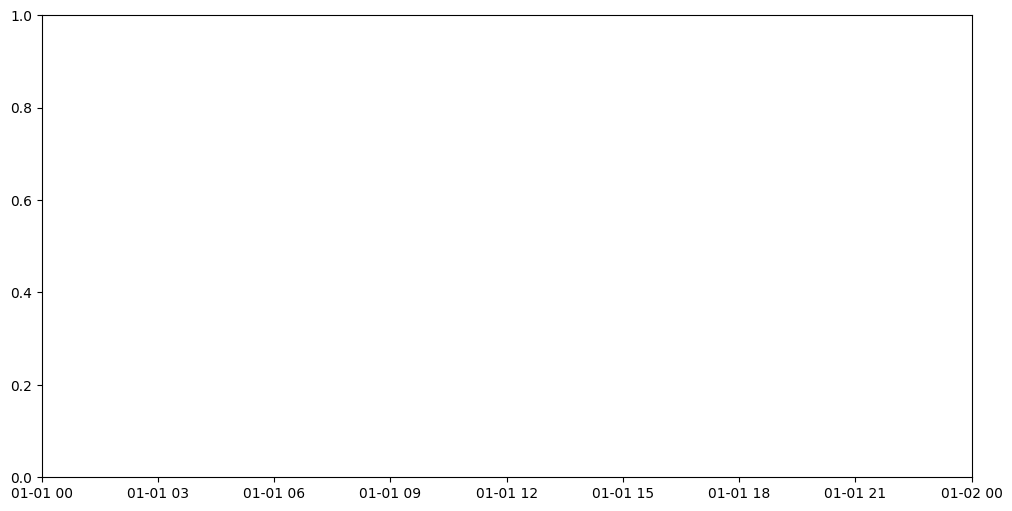

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
#get time column
time_column = df_with_date.select(pl.col("Date")).cast(pl.Date)
# merge time column with factors
filtered_factors_bf_timed = pl.DataFrame(np.array(filtered_factors_bf)).with_columns(time_column)
# plot the factors
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(data=filtered_factors_bf_timed,x="Date", ax=ax)

#get volatilities
filtered_log_vols_bf=bif_filter.get_filtered_volatilities()
#Plot all 5 volatilities
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.lineplot(data=filtered_log_vols_bf, ax=ax)

In [ ]:
# Extract the date column (ensure it's in pandas datetime format)
# If df_with_date is polars:
time_column_pd = df_with_date.select(pl.col("Date").cast(pl.Date)).to_pandas()['Date']
# If df_with_date is already pandas:
# time_column_pd = df_with_date['Date']


# Extract factors (first K columns) and log-vols (next K columns)
filtered_factors = filtered_states_bf[:, :K]
filtered_log_vols = filtered_states_bf[:, K:]

# Create meaningful column names
factor_cols = [f'Factor_{i+1}' for i in range(K)]
logvol_cols = [f'LogVol_{i+1}' for i in range(K)]

# Create pandas DataFrame
plot_df = pd.DataFrame(filtered_factors, columns=factor_cols, index=time_column_pd)
for i, col_name in enumerate(logvol_cols):
    plot_df[col_name] = filtered_log_vols[:, i]

print("DataFrame head for plotting:")
print(plot_df.head())

DataFrame head for plotting:

Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  LogVol_1  \
Date                                                                     
1963-07-01  0.002974 -0.011820 -0.020005 -0.014010  0.001343 -6.604013   
1963-08-01 -0.000605  0.025549  0.013216  0.015082  0.000434 -6.851611   
1963-09-01 -0.003517 -0.012147 -0.006991 -0.006858  0.006002 -6.960335   
1963-10-01 -0.007499  0.005936  0.002555  0.004893  0.001265 -7.084911   
1963-11-01 -0.024195 -0.001111  0.002729  0.006918 -0.000796 -7.108046   

            LogVol_2  LogVol_3  LogVol_4   LogVol_5  
Date                                                 
1963-07-01 -7.314861 -7.713257 -7.407418  -8.826376  
1963-08-01 -7.733485 -8.342829 -7.913797  -9.705939  
1963-09-01 -7.999481 -8.685264 -8.205030 -10.160708  
1963-10-01 -8.277076 -9.037360 -8.509128 -10.653313  
1963-11-01 -8.502215 -9.302647 -8.740235 -10.976349

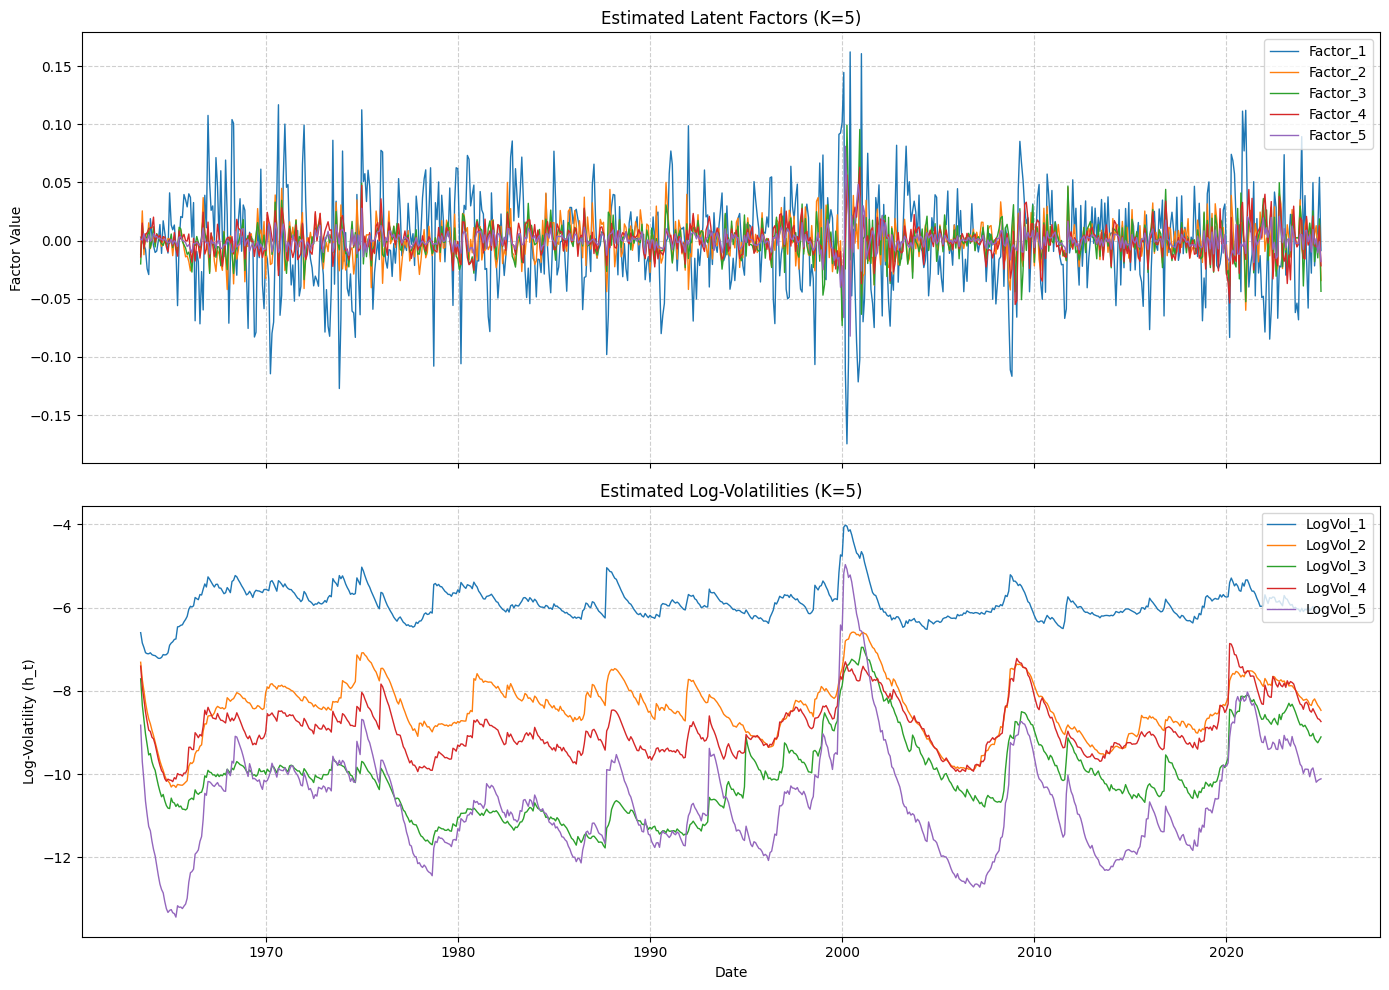

In [ ]:
# --- Plotting ---
num_states = K # Number of factors OR log-vols to plot

# Create figure with 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10), sharex=True) # Share x-axis

# Plot Factors on the first subplot (axes[0])
axes[0].set_title(f'Estimated Latent Factors (K={K})')
for i in range(num_states):
    col_name = factor_cols[i]
    axes[0].plot(plot_df.index, plot_df[col_name], label=col_name, linewidth=1)
axes[0].set_ylabel('Factor Value')
axes[0].legend(loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Log-Volatilities on the second subplot (axes[1])
axes[1].set_title(f'Estimated Log-Volatilities (K={K})')
for i in range(num_states):
    col_name = logvol_cols[i]
    axes[1].plot(plot_df.index, plot_df[col_name], label=col_name, linewidth=1)
axes[1].set_ylabel('Log-Volatility (h_t)')
axes[1].legend(loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.6)

# Common X-axis label
axes[1].set_xlabel('Date')

# Improve layout and display
plt.tight_layout()
plt.show()

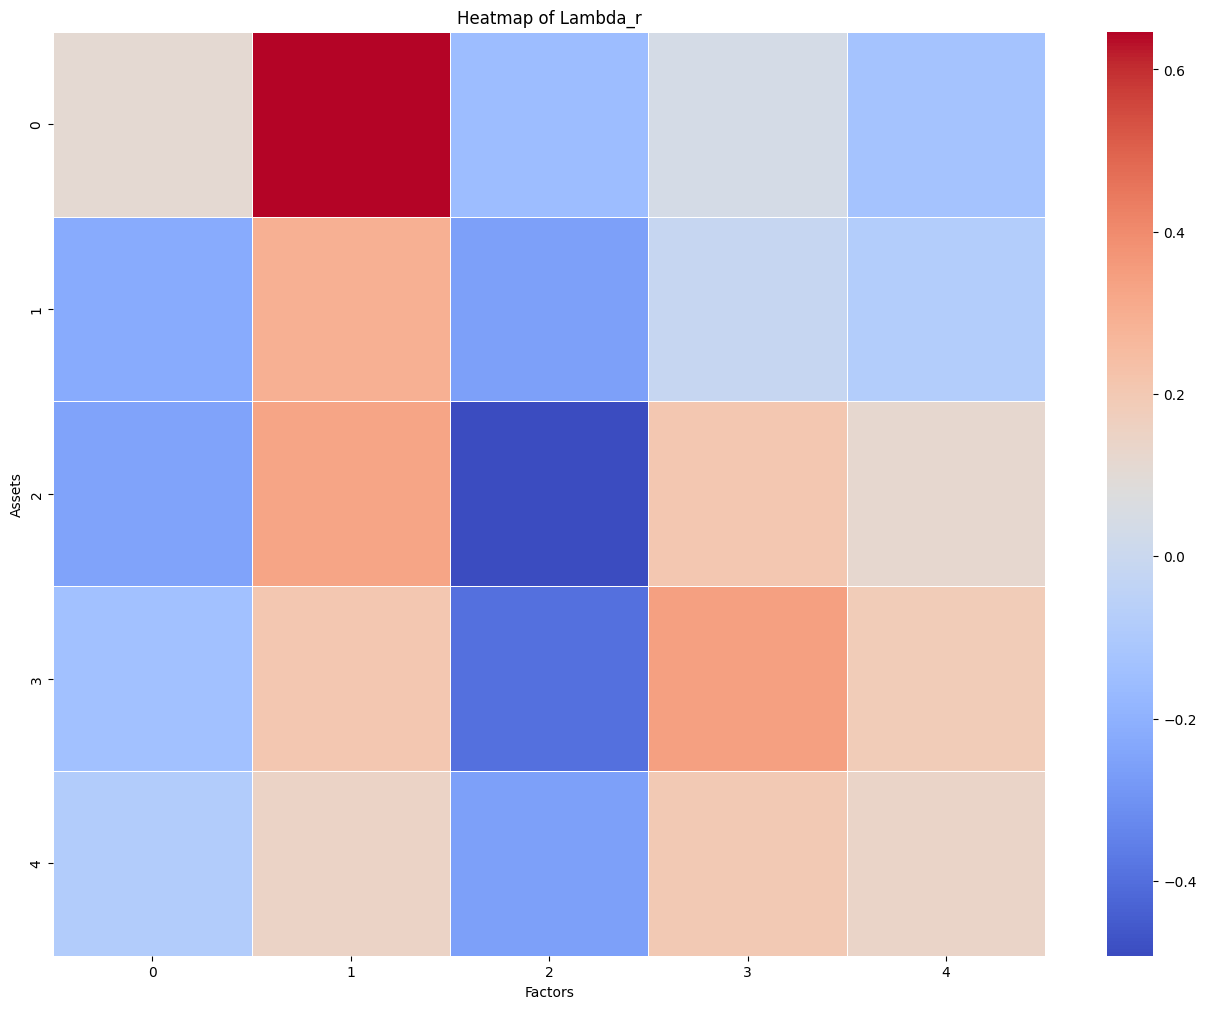

In [ ]:
#Create a heatmap of factor loadings lambda_r
import matplotlib.pyplot as plt
import seaborn as sns
lambda_r=bif_params.lambda_r

# Create a heatmap of lambda_r
plt.figure(figsize=(16, 12))
sns.heatmap(bif_params.Phi_f, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Lambda_r')
plt.xlabel('Factors')
plt.ylabel('Assets')
plt.show()

variance of each z-series (should be ~1): 1.0268042904909802

first five LJ p-values (lag 10):
[np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan)]

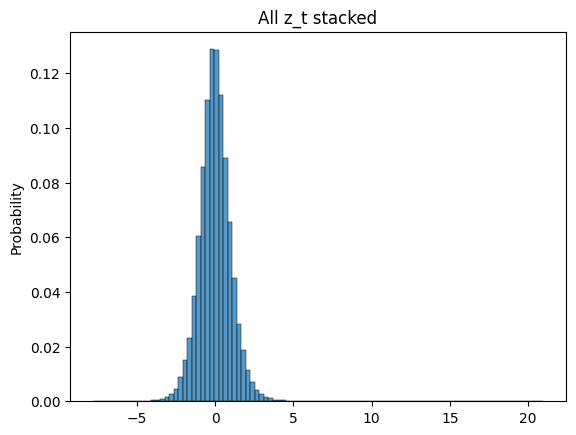

In [ ]:
# After you rebuild z_t with Σ_{t|t-1} ...

print('variance of each z-series (should be ~1):',
      standardized_residuals_bif_df.var().mean())

print('first five LJ p-values (lag 10):',
      [acorr_ljungbox(standardized_residuals_bif_df[col]**2,
                      lags=[10]).iloc[0,1]
       for col in standardized_residuals_bif_df.columns[:5]])

# visual check
import matplotlib.pyplot as plt, seaborn as sns
sns.histplot(standardized_residuals_bif_df.values.flatten(), bins=100, stat='probability')
plt.title('All z_t stacked'); plt.show()


In [ ]:
import numpy as np
from scipy.stats import kurtosis
from statsmodels.stats.stattools import jarque_bera
from scipy.special import digamma
from scipy.optimize import brentq

# --- POST-HOC STUDENT-t CHECK ---------------------------------------------
# 1. Flatten and clean residuals
z = standardized_residuals_bif_post_burn.values.flatten()
z = z[~np.isnan(z)]

# 2. Define score function for ν MLE
def score(nu, z):
    term1 = np.log1p(z**2 / nu).mean()
    term2 = (
        digamma((nu + 1) / 2)
        - digamma(nu / 2)
        + np.log(nu / 2)
        - np.log((nu + 1) / 2)
    )
    return term1 - term2

# 3. Estimate ν via root finding with fallback
try:
    nu_hat = brentq(score, 2.1, 200, args=(z,))
except ValueError:
    # Method-of-Moments fallback: excess kurtosis = 6/(ν-4)
    k_ex = kurtosis(z, fisher=True)
    nu_hat = 6.0 / k_ex + 4.0

print(f"Estimated ν = {nu_hat:.2f}")

# 4. Compare excess kurtoses
k_emp = kurtosis(z, fisher=True)
k_t   = np.inf if nu_hat <= 4 else 6 / (nu_hat - 4)
print(f"Empirical excess kurtosis : {k_emp:.3f}")
print(f"Implied by t({nu_hat:.1f})   : {k_t:.3f}")

# 5. Jarque–Bera p-value under Gaussian
jb_stat, jb_p, skew, kurt = jarque_bera(z)
print(f"JB p-value (Gaussian)     : {jb_p:.4f}")

# 6. Monte-Carlo for JB p-values under t(ν̂)
rng = np.random.default_rng(0)
sim_p = []
for _ in range(10_000):
    zs = rng.standard_t(df=nu_hat, size=z.size)
    _, p, _, _ = jarque_bera(zs)
    sim_p.append(p)

print(f"Median JB p-value (t)     : {np.median(sim_p):.4f}")


Estimated ν = 5.27

Empirical excess kurtosis : 4.739

Implied by t(5.3)   : 4.739

JB p-value (Gaussian)     : 0.0000

Median JB p-value (t)     : 0.0000

In [ ]:
import numpy as np
from statsmodels.stats.stattools import jarque_bera

# residuals_df = standardized_residuals_bif_post_burn  # your DataFrame
alpha    = 0.05
nu_hat   = 5.27         # from your earlier estimation
n_reps   = 1000         # number of MC draws per series
rng      = np.random.default_rng(12345)

pass_norm = 0.0
pass_t    = 0.0

# Loop over each of the 95 series
for col in residuals_df.columns:
    data = residuals_df[col].dropna().values
    n    = data.size

    # 1) Normal test on the real series
    _, p_norm, _, _ = jarque_bera(data)
    pass_norm += (p_norm > alpha)

    # 2) MC under t(ν̂)
    # Draw (n_reps × n) array of t variates
    sims = rng.standard_t(df=nu_hat, size=(n_reps, n))
    # Compute JB p-values for each replicate
    pvals = np.array([jarque_bera(s)[1] for s in sims])
    # Fraction of those M-C series that pass at 5%
    pass_t += (pvals > alpha).mean()

# Convert counts to rates
pass_norm_rate = pass_norm / len(residuals_df.columns)
pass_t_rate    = pass_t    / len(residuals_df.columns)

print(f"Per‐series JB pass‐rate (Gaussian) : {pass_norm_rate:.1%}")
print(f"Per‐series JB pass‐rate (t({nu_hat:.1f})) : {pass_t_rate:.1%}")


Per‐series JB pass‐rate (Gaussian) : 2.1%

Per‐series JB pass‐rate (t(5.3)) : 0.1%